# Fundamentos de Aprendizaje Automático y Reconocimiento de Patrones

# Práctico 6

## Se importan bibliotecas

In [2]:
# Se importan las bibliotecas que se utilizarán
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs

from scipy import signal
from scipy.io import wavfile
from scipy import optimize

import IPython.display as ipd
from IPython.display import Image

import time
import os

from fuaa_utils_p6 import split_data
from fuaa_utils_p6 import mostrar_senhales
from fuaa_utils_p6 import comparar_dos_clases
from fuaa_utils_p6 import plot_features
from fuaa_utils_p6 import features_from_arrays
from fuaa_utils_p6 import generar_conjunto_entrenamiento
from fuaa_utils_p6 import mostrar_superficie_decision
from fuaa_utils_p6 import plot_svm_multiclase
from fuaa_utils_p6 import extraer_caracteristicas
from fuaa_utils_p6 import mostrar_grid_search_results
from fuaa_utils_p6 import mostrar_matriz_confusion

from fuaa_utils_p6 import plotLine, plotSvm

%matplotlib inline

# Sacar para el repartido
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## Objetivos

- Plantear la **maximización del margen** en el algoritmo SVM y su resolución en el **espacio dual**.
- Formular las ventajas prácticas que puede presentar resolver el **problema dual**.
- Adquirir cierta intuición en cuanto a la solución brindada por el algoritmo SVM mediante su aplicación para **separar** entre distintos tipos de **sonidos** utilizando sólo dos características.
- Aplicar SVM en un problema de mediana escala para **clasificar** entre 10 categorías de **sonidos urbanos**.
- **Optimizar** los parámetros de un **clasificador SVM** utilizando la biblioteca *scikit-learn*.
- **Optimizar** los parámetros de un **clasificador SVM** utilizando el paquete de optimización *scipy.optimize*.
- Aplicar correctamente el mecanismo de **validación cruzada** como forma de estimar la bondad del clasificador.
- Interpretar la información brindada por una matriz de confusión.

#  Lista de ejercicios

[Ejercicio 1](#Ejercicio1): Formulación del algoritmo C-SVM       
[Ejercicio 2](#Ejercicio2): Separando sonidos con características intuitivas   
[Ejercicio 3](#Ejercicio3): SVM en un problema de mediana escala multiclase   
[Ejercicio 4](#Ejercicio4): Resolviendo SVM con kernel *linear* con un paquete de optimización

# Ejercicio 1: Formulación del algoritmo SVM
<a id="Ejercicio1"></a>

El algoritmo $\textit{C-SVM}$ da lugar al siguiente problema de optimización:

\begin{align}\label{csvm} 
    \left\{ \begin{aligned}  
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\min}
&  & f(\mathbf{w}, \mathbf{\xi}) = \frac{1}{2}||\mathbf{w}||^{2} + C \sum_{n=1}^{N} \xi_n \\
& \text{sujeto a} \\   
& & & y_n ( \mathbf{w}^T\Phi(x_n)  + b) \geq 1 - \xi_n \quad \forall n=1,\ldots,N\\  
& & & \xi_n \geq 0 \\   
   \end{aligned}   \right.  
\end{align} 

**Parte a)** Escribir el Lagrangiano $\mathcal{L}$ del problema. 

**Respuesta:** 

$\mathcal{L}(\mathbf{w},b, \mathbf{\xi}, \mathbf{\alpha}) = \frac{1}{2}||\mathbf{w}||^{2} + C \sum_{n=1}^{N} \xi_n - \sum_{n=1}^{N} \mathbf{\alpha}_n(y_n(\mathbf{w}^T \Phi(x_n)  + b)-1 + \xi_n) $ 

**Parte b)** Argumentar que el valor del Lagrangiano $\mathcal{L}$ está acotado superiormente por la función de costo original $f$. 

**Respuesta:** 
Los $\alpha_n \geq 0$ y $(y_n(\mathbf{w}^T \Phi(x_n)  + b)-1 + \xi_n)\geq 0$ por lo cual la sumatoria dará $\geq 0$. Esto significa que la función de costo original está restada por algo $\geq 0$, lo que genera un valor más pequeño o igual que la función de costo original, concluyendo que la misma es cota superior del lagraniano. 

## El problema primal

**Parte c)** Se define la función $\theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} )=\underset{\boldsymbol{\alpha}, \boldsymbol{\beta}; \alpha_n \geq 0, \beta_n \geq 0}{\max}\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\beta} ) $. Argumentar que resolver

$$
\underset{\mathbf{w}, b, \mathbf{\xi}}{\min} \theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} )
$$

es equivalente a encontrar el mínimo de  $f(\mathbf{w}, \mathbf{\xi})$ con las restricciones del problema.

**Respuesta:** 
Como la cota superior de $\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha},\boldsymbol{\beta})$ es la función de costo vamos a querer maximizar con respecto a los $\alpha$ y $\beta$. Por el contrario, w y b y $\xi$ los vamos a querer minimizar para minimizar la función de costo original. 

## El Problema dual

 Se define ahora la función *dual* $$\theta_{\mathcal{D}}(\boldsymbol{\alpha}, \boldsymbol{\beta} )=\underset{\mathbf{w},b,\boldsymbol{\xi}}{\min}\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\beta} ).$$
 
En general se cumple para el óptimo del problema dual $d^*$ que
$$d^* = \underset{\boldsymbol{\alpha}, \boldsymbol{\beta}}{\max} \theta_{\mathcal{D}}(\boldsymbol{\alpha}, \boldsymbol{\beta}) \leq  \underset{\mathbf{w}, b, \mathbf{\xi}}{\min} \theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} ) = p^*$$
 
Sin embargo, en el caso en que tanto la función a optimizar $f$ como sus restricciones son convexas se cumple que $d^*$ coincide con $p^*$. Este es el caso de SVM.

Desde el punto de vista práctico resolver el problema *primal* implica maximizar respecto a los multiplicadores de Lagrange primero y luego minimizar respecto a los pesos y las variables *slack*. Resolver el problema *dual* en cambio implica minimizar respecto a los pesos y las variables *slack* primero y luego maximizar respecto a los multiplicadores.


**Parte d)** Mostrar que el problema dual puede escribirse como:
\begin{align*}
    \left\{ \begin{aligned}  
& \underset{\boldsymbol{\alpha}}{\min}
& & \frac{1}{2}\boldsymbol{\alpha}^{T}\boldsymbol{Q}\boldsymbol{\alpha} - \mathbb{1}^{T}\boldsymbol{\alpha} \\
& \text{sujeto a} \\
& & & 0 \leq \alpha_n \leq C \\ 
& & & \sum_n \alpha_n y_n = 0 \\ 
   \end{aligned}   \right.   \quad \tag{Dual C-SVM}
\end{align*}  
con $Q_{ij} = y_i y_j K(x_i,x_j)$              

**Respuesta:** 

Como $\theta_{\mathcal{D}}(\boldsymbol{\alpha}, \boldsymbol{\beta} )=\underset{\mathbf{w},b,\boldsymbol{\xi}}{\min}\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\beta})$ vamos a calcular el mínimo. Para ello se calculan las derivadas parciales y se igualan a cero:

$\frac{d\mathcal{L}}{db}=-\sum_n \alpha_n y_n = 0 $

$\nabla_w\mathcal{L}=w - \sum_{n=1}^{N} \mathbf{\alpha}_ny_n \Phi(x_n) = 0 $

$\nabla_{\xi}\mathcal{L}= \sum_{n=1}^{N} (C -\mathbf{\alpha}_n) = 0 $

Entonces se tiene:

$\sum_n \alpha_n y_n = 0$

$w = \sum_{n=1}^{N} \mathbf{\alpha}_ny_n \Phi(x_n)$

$ \sum_{n=1}^{N} (C -\mathbf{\alpha}_n) = 0$

Sustituyendo queda:

$\mathcal{L}(\mathbf{\alpha}) = \sum_{n=1}^{N} \mathbf{\alpha}_n  - \frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{M} \mathbf{\alpha}_n\mathbf{\alpha}_my_ny_m\Phi(x_n)\Phi(x_m)^T  $ 

Ahora como se busca maximizar se multiplica por -1, quedando el mínimo.



**Parte e)** Mencione por qué puede resultar más conveniente resolver el problema dual.

**Respuesta:** 
Resulta más conveniente cuando la dimensión del problema d+1 es mayor que la cantidad de muestras N. (Menos cantidad de variables involucradas)

# Ejercicio 2: Separando sonidos con características intuitivas
<a id="Ejercicio2"></a>

En los ejercicios 2 y 3 de este práctico se trabajará con la base de datos [**Urban Sound**](https://urbansounddataset.weebly.com/).

## Base de datos Urban Sound

La base de datos está conformada por una serie de fragmentos de audios en las que se escuchan sonidos característicos de un entorno urbano. En concreto, la base cuenta con sonidos pertenecientes a las siguientes 10 categorías:     

0. aire acondicionado (air_conditioner)
0. bocina de auto (car_horn)
0. niños jugando (children_playing)  
0. ladrido de perros (dog_bark)
0. taladrado (drilling)  
0. motor moderando (engine_idling)  
0. disparo de arma de fuego (gun_shot)  
0. martillo neumático (jackhammer)  
0. sirena (siren)  
0. música callejera (street_music)   

Los fragmentos tienen una duración de 4 segundos. Los fragmentos fueron extraídos de grabaciones más grandes utilizando ventanas de 4 segundos solapadas entre sí por 2 segundos.  

Los datos se proveen separados en 10 *folds*, tomando en cuenta que en *folds* distintos NO existen extractos de un mismo audio.  

### Distribución de la base de datos

La siguiente celda lee la *metadata* de la base de datos y genera un gráfico que muestra la distribución de las clases según los *folds* y la cantidad de audios por clase.

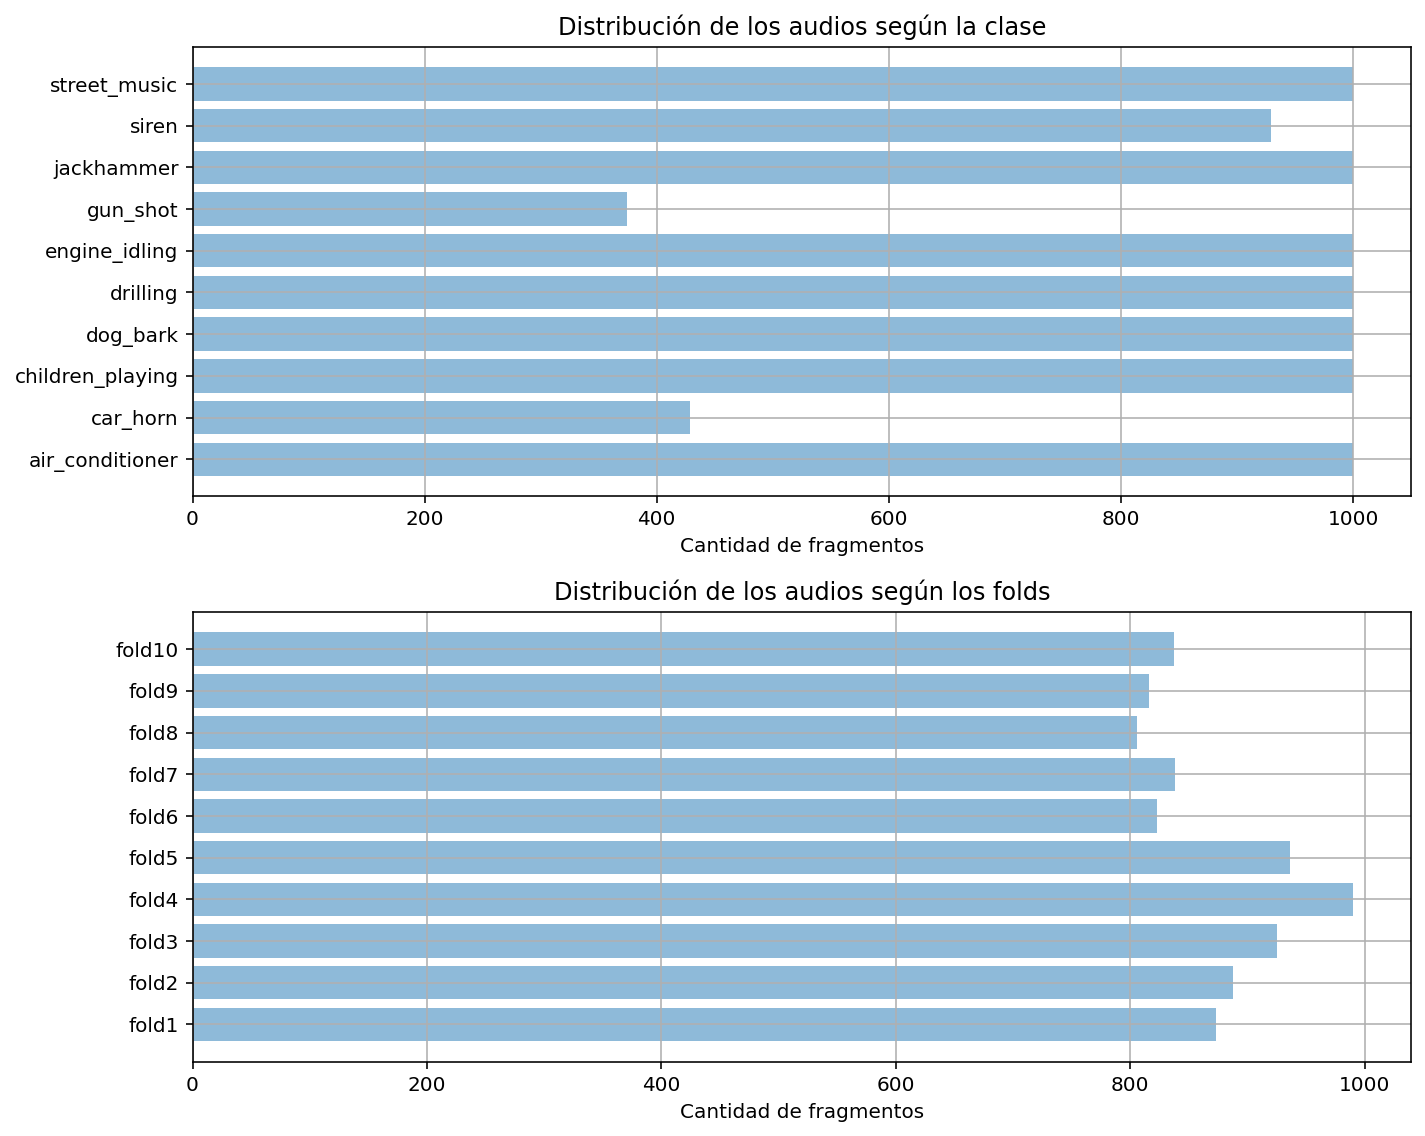

In [3]:
file_metadata_path = 'dataset/metadata'
metadata = []

with open(os.path.join(file_metadata_path, 'UrbanSound8K.csv'), 'r') as file_metadata:
    line1 = file_metadata.readline()
    metadata.append(line1.split('\n')[0].split(','))
    for line in file_metadata:
        metadata.append(line.split('\n')[0].split(','))
        metadata[-1][5] = metadata[-1][5].zfill(2)

headers = metadata[0]
all_data = np.array(metadata[1:])

folders = split_data(all_data)

uniqueValues, occurCount = np.unique(all_data[:, 6], return_counts=True)
objects = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
           'street_music')
y_pos = np.arange(len(objects))

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.barh(y_pos, occurCount, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Cantidad de fragmentos')
plt.title('Distribución de los audios según la clase')
plt.grid()

plt.subplot(2, 1, 2)
_, occurCount2 = np.unique(all_data[:, 5], return_counts=True)
objects2 = ('fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7',
            'fold8', 'fold9', 'fold10')
y_pos2 = np.arange(len(objects2))
plt.barh(y_pos, occurCount2, align='center', alpha=0.5)
plt.yticks(y_pos2, objects2)
plt.xlabel('Cantidad de fragmentos')
plt.title('Distribución de los audios según los folds')
plt.grid()
plt.tight_layout()

En este ejercicio se buscará separar las siguientes tres clases de sonidos pertenecientes al *fold 3*:

5. motor moderando (engine_idling)  
5. disparo de arma de fuego (gun_shot)  
5. martillo neumático (jackhammer)  

La distribución de los fragmentos por clase en el *fold 3* es la siguiente:

- motor moderando: 107 fragmentos obtenidos a partir de 10 grabaciones
- disparo de arma de fuego: 36 fragmentos obtenidos a partir de 12 grabaciones
- martillo neumático: 120 fragmentos obtenidos a partir de 5 grabaciones

La siguiente celda muestra las señales correspondientes a una determinada clase y un determinado *fold*.

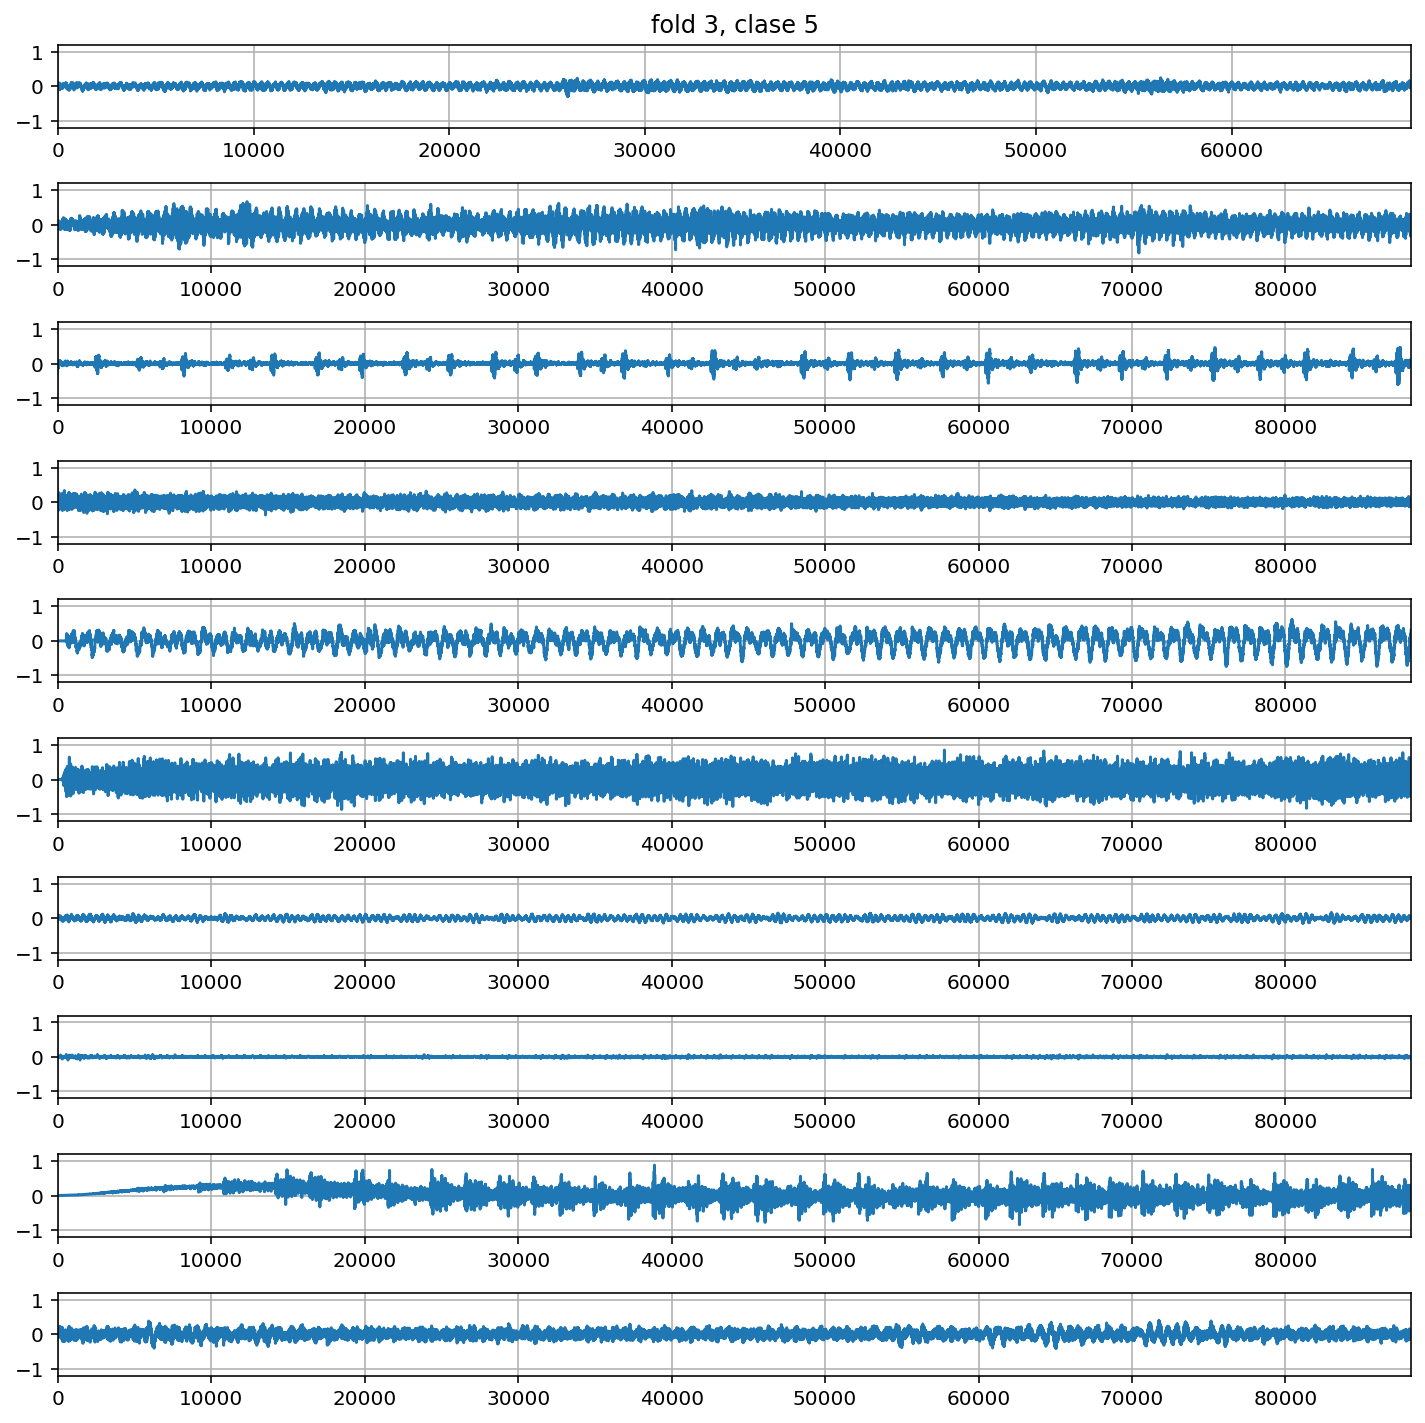

In [4]:
path_audios = 'dataset/audios'
fold_to_show = 3
class_to_show = 5
mostrar_senhales(path_audios, fold_to_show, class_to_show)

La siguiente celda permite comparar las señales de *folds* y/o clases diferentes.

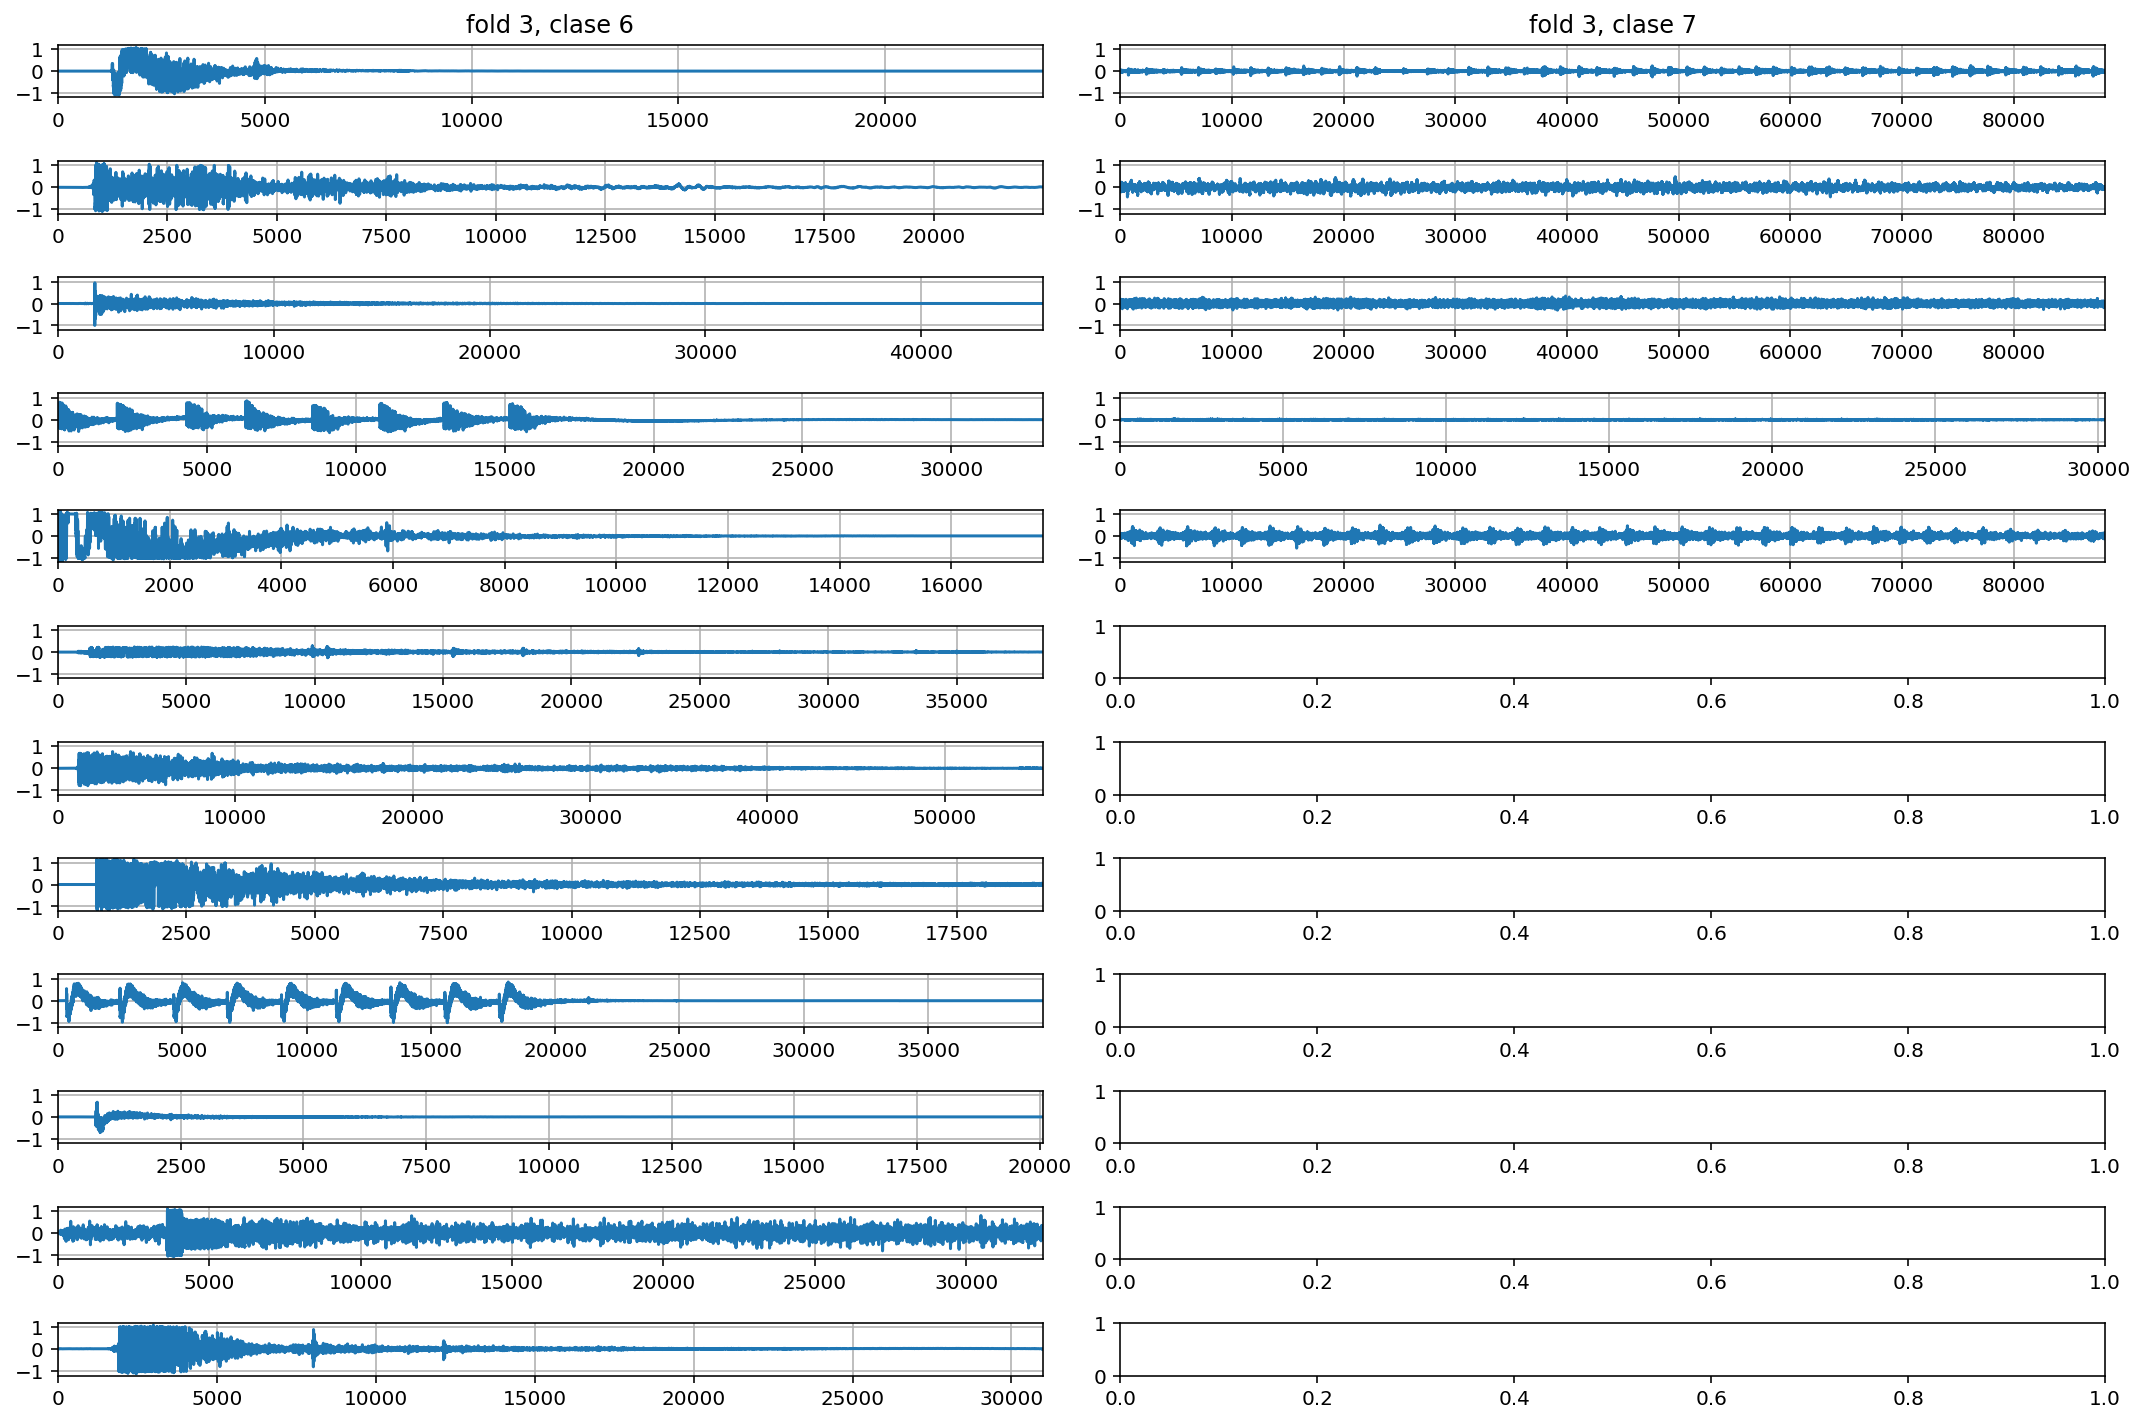

In [5]:
fold1_to_compare = 3
class1_to_compare = 6
fold2_to_compare = 3
class2_to_compare = 7
comparar_dos_clases(path_audios, fold1_to_compare, class1_to_compare,
                    fold2_to_compare, class2_to_compare)

## Características

En el presente ejercicio se buscará ganar intuición sobre como trabaja el clasificador SVM, para ello se describirá el comportamiento de las señal utilizando dos características temporales intuitivas.

Cada fragmento se divide en ventanas solapadas en un 50% de 2048 muestras y para cada ventana se calculan las siguientes características:

 - ZCR (Zero-Crossing-Rate): la cantidad de cruces por cero de las muestras de la señal.
    
 - RMS (Root-Mean-Square): la raíz del valor cuadrático medio de las muestras de la señal, también conocida como medida de la energía de la señal.
    
$$
x_{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}x_{i}^2}
$$

Finalmente se obtiene un único valor de *ZCR* y *RMS* representativo del fragmento, aplicando sobre los valores obtenidos en todas las ventanas una de las siguientes operaciones: mean(), max(), min() o std_dev().

La extracción de características fue realizada previamente y la siguiente celda las levanta:

In [6]:
# se levantan las características (ZCR, RMS) calculadas para los audios de cada fold
folders_features = np.load('dataset/linealfeat_all_folds.npy',
                           allow_pickle=True)  # objeto python de largo 10
n_folds = len(folders_features)
print('Se levantaron las características precalculadas de %d folds.' % n_folds)
print('El primer fold tiene %d segmentos de audio.' % len(folders_features[0]))

Se levantaron las características precalculadas de 10 folds.
El primer fold tiene 873 segmentos de audio.


## Ejercicios

**Ejercicio:** En primera instancia se intentará separar las clases 6 y 7 del fold 3 utilizando como características el ZCR promedio y la desviación estandar del RMS.  Las siguientes celdas generan el conjunto de datos a utilizar para ello.

/home/jess/Desktop/FUAA/practico_06/fuaa_utils_p6.py:266: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.vstack(np.asarray(features))
/home/jess/Desktop/FUAA/practico_06/fuaa_utils_p6.py:267: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.concatenate(np.asarray(labels))


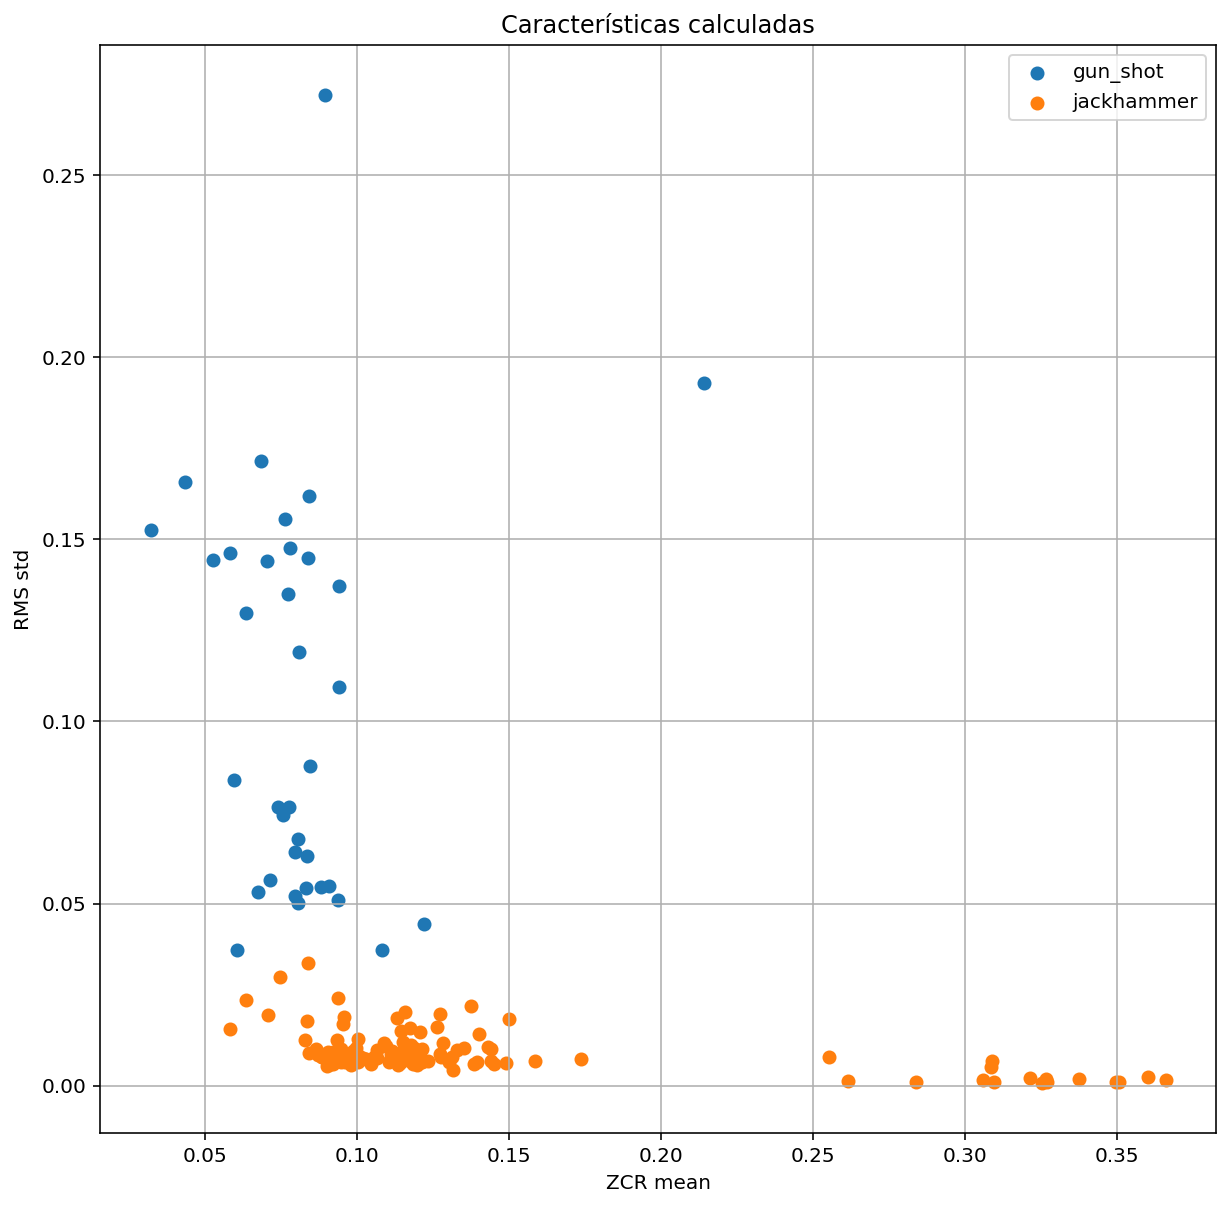

In [7]:
clases_a_separar = [6, 7]
Xtrain, ytrain = generar_conjunto_entrenamiento([3], clases_a_separar, 'mean',
                                                'std', folders_features,
                                                folders, objects)

**Pregunta:** ¿Le parece razonable la distribución de los puntos para el caso del disparo y el martillo neumático? ¿Qué comportamiento de la señal logran capturar las características elegidas?

**Respuesta:**  ...

## Clasificación 

En esta parte se compararán las soluciones de *Regresión Logística* y *SVM*. En el caso de SVM se trabajará con un *kernel linear*.

**Ejercicio:** Completar la siguiente celda y comparar las soluciones brindadas por *Regresión Logística* y *SVM* con parámetros por defecto.   

In [ ]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

# Se estandarizan las características
X=np.array(Xtrain)
y=np.array(ytrain)

# Se entrena el clasificador de regresión logística
clf_logreg = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)

# Se entrena el clasificador svm con kernel linear

clf_svm = np.dot(np.multiply(alpha,y),X)

# Se obtiene el número de vectores de soporte del clasificador
# num_vec_sop =

# Se obtiene el tamaño del margen
# tam_margen =

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

print('El clasificador SVM tiene %d vectores soporte.' % num_vec_sop)
print('El tamaño del márgen es %f' % tam_margen)

# Se muestra el resultado de los clasificadores entrenados anteriormente
mostrar_superficie_decision(Xtrain_std, ytrain, clf_svm, clf_logreg, objects)

**Ejercicio:** ¿Cómo varía el número de soportes en función de $C$? ¿Y el margen? Puede ser útil crear una nueva celda y generar una gráfica que muestre la variación de estas cantidades con $C$.

**Respuesta:**  ...

## Clasificación SVM multiclase

En esta parte se utilizará SVM para clasificar entre tres clases pertenecientes a un mismo *fold*.

In [8]:
# Se define el fold y las clases a separar
fold = 3
c1 = 5
c2 = 6
c3 = 7

# Se calculan las características
op_type1_1 = 'mean'
op_type2_1 = 'std'

class_features = []

for i in range(10):
    fi = folders_features[fold - 1][folders[fold - 1][:, -2] == np.str(i)]
    fi = features_from_arrays(fi, tipo_c1=op_type1_1, tipo_c2=op_type2_1)
    class_features.append(fi)
    
class_features = np.array(class_features, dtype="object")

/tmp/ipykernel_172549/676479259.py:14: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fi = folders_features[fold - 1][folders[fold - 1][:, -2] == np.str(i)]


Se arma el conjunto de entrenamiento con las clases elegidas.

In [9]:
Xtrain_3 = np.vstack(
    [class_features[c1], class_features[c2], class_features[c3]])

ytrain_3 = np.hstack([
    np.zeros(len(class_features[c1])),
    np.ones(len(class_features[c2])),
    np.ones(len(class_features[c3])) * 2
])

**Ejercicio:** Entrenar un clasificador SVM que logre separar correctamente completamente el conjunto de entrenamiento. 

In [ ]:
scaler = StandardScaler()
scaler.fit(Xtrain_3)
Xtrain_3 = scaler.transform(Xtrain_3)

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

# clf_svm =

# num_vec_sop = 

# E_in = 

#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

plot_svm_multiclase(Xtrain_3, ytrain_3, clf_svm, op_type1_1, op_type2_1)
print('El clasificador SVM tiene %d/%d vectores soporte.' % (num_vec_sop, len(Xtrain_3)))
print('E_in = %f' % E_in)

**Pregunta:** ¿Cuál es el criterio que usa la implementación SVC para clasificar múltiples clases?

**Respuesta:**  ...

**Pregunta:** ¿Y en el caso de Regresión Logística? ¿Cómo se lleva a cabo la clasificación multiclase?

**Respuesta:**  ...

<a id="Ejercicio3"></a>
# Ejercicio 3: SVM en un problema de mediana escala multiclase

### Descripción del ejercicio

En este ejercicio se utilizará un clasificador SVM para separar los sonidos  urbanos de la base de datos *Urband Sound*. Se dividirán los *folds* en conjuntos de entrenamiento, validación y test. Los primeros 6 folds conformarán el conjunto de entrenamiento, los folds 7-8 el de validación y los folds 9-10 el de test.

### Características

Se utilizarán las mismas características que en el *paper* [A Dataset and Taxonomy for Urban Sound Research](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf) que es el trabajo que presentó la base de datos. 

#### Coeficientes Cepstrales de Frecuencia Mel (MFCC)

Los Coeficientes Cepstrales de Frecuencia Mel (MFCC) son características que representan propiedades del espectro de tiempo corto de una señal de audio. En particular, permiten capturar la evolución de la envolvente espectral, lo que es de especial relevancia para discriminar el tipo de sonido. Por esta razón, son muy utilizados para el procesamiento y análisis de señales de voz, sonidos ambientales y música.


El cálculo de los MFCC se representa en el esquema de la siguiente figura.  
<img src="figuras/mfcc_bloques.png">  

La señal de entrada $x[n]$ es dividida en tramas temporales solapadas, mediante una ventana suavizante $w[n]$ y se calcula la magnitud del espectro de cada trama $|X[k]|$ usando la DFT. La magnitud del espectro pasa por un banco de filtros que sigue aproximadamente la respuesta en frecuencia de la percepción auditiva humana. Los componentes de frecuencia que pasan por cada filtro del banco $V_l[k]$ son ponderados por la respuesta del filtro y se suma su magnitud al cuadrado, lo que corresponde a un cálculo de energía. Luego se calcula el logaritmo de la señal de salida y se convierte al dominio del tiempo usando la Transformada de Coseno Discreto (DCT). Además de volver al dominio del tiempo, la DCT descompone los coeficientes de forma de que cada coeficiente tiene información diferente a la de los demás coeficientes. Es habitual conservar solo los primeros coeficientes de la DCT, los cuales se relacionan con la envolvente espectral de la señal. Para capturar la evolución temporal de los MFCC se suele calcular además la derivada de primer y segundo orden de cada coeficiente.  

Para el cálculo de los MFCC que se usarán a continuación, se segmenta la señal de audio en tramas de tamaño 23.2 ms con un 50% de solapamiento entre tramas y se aplica un banco de filtros con 40 bandas Mel distribuidas entre 0 y 22050 Hz. A la salida de la DCT se conservan los primeros 25 coeficientes MFCC. Luego, el comportamiento de cada coeficiente MFCC a lo largo de todas las tramas de un archivo de audio se describe calculando las siguientes características: mínimo, máximo, mediana, media, varianza,  asimetría, kurtosis y la media y varianza de la primera y segunda derivadas de la señal, resultando en un vector de características de dimensión 275.

A continuación se muestran los primeros 12 MFCC calculados para los dos archivos de ejemplo.  
<img src="figuras/gunshot.png">
<img src="figuras/jackhammer.png">


Dado que la extracción de características lleva un tiempo no despreciable, las mismas fueron precalculadas. A continuación se levantan las mismas desde el directorio *dataset*. Se divide el conjunto de datos en *entrenamiento* y *validación*

In [ ]:
# Se construye el conjunto de entrenamiento con los primeros seis folds.
features_train, labels_train, fold_indices_train = extraer_caracteristicas(
    [1, 2, 3, 4, 5, 6])
print('El conjunto de entrenamiento cuenta con %d audios' %
      len(features_train))

# Se construye el conjunto de validación con los folds 7 y 8.
features_val, labels_val, fold_indices_val = extraer_caracteristicas([7, 8])
print('El conjunto de validación cuenta con %d audios' % len(features_val))

# Los folds 9 y 10 se utilizarán para test. No se provén las etiquetas del 
# conjunto de test.
features_test, labels_test, _ = extraer_caracteristicas([9, 10])
print('El conjunto de test cuenta con %d audios' % len(features_test))

## Parte 1: SVM con kernel 'rbf'

Entrenar el clasificador SVM con el kernel por defecto y parámetro $\gamma=$'auto', utilizando el conjunto de entrenamiento. 

In [ ]:
#######################################################
######## EMPIEZA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

# clf_svm =

# E_in = 

# E_val = 

#######################################################
######## TERMINA ESPACIO PARA COMPLETAR CODIGO ########
#######################################################

print("E_in = %f\nE_val = %f" % (E_in, E_val))

**Pregunta:** Describa el punto de funcionamiento del clasificador

**Respuesta:** ...

**Pregunta:** ¿Cuál es el número de vectores de soporte? ¿Es útil dicha información?

**Respuesta:** ...

## Parte 2:  anticipando el comportamiento en validación

En ciertas oportunidades es deseable estimar el desempeño del *conjunto de validación* con el *conjunto de entrenamiento* para no contaminar los mismos innecesariamente. Una forma habitual es hacer *validación cruzada* con el conjunto de entrenamiento.  

A continuación se hará validación cruzada con el conjunto de entrenamiento. Para ello se utilizará la función `cross_validate()` del paquete *model selection*. Lo haremos de tres formas diferentes.

**Las siguientes tres celdas tienen un tiempo de ejecución mayor a lo habitual.**

In [ ]:
# validación cruzada 6-fold con cv=6
scores = cross_validate(clf_svm,
                        features_train,
                        labels_train,
                        return_train_score=True,
                        cv=6)

print('Accuracy con conjunto de entrenamiento = %f' % scores['train_score'].mean())
print('Accuracy con conjunto de validación = %f' % scores['test_score'].mean())

In [ ]:
# validación cruzada 6-fold utilizando cv = ShuffleSplit
cv = ShuffleSplit(n_splits=6, test_size=1 / 6, random_state=0)
scores = cross_validate(clf_svm,
                        features_train,
                        labels_train,
                        return_train_score=True,
                        cv=cv)

print('Accuracy con conjunto de entrenamiento = %f' % scores['train_score'].mean())
print('Accuracy con conjunto de validación = %f' % scores['test_score'].mean())

In [ ]:
# validación cruzada 6-fold utilizando cv = PredefinedSplit
cv = PredefinedSplit(test_fold=fold_indices_train)
scores = cross_validate(clf_svm,
                        features_train,
                        labels_train,
                        return_train_score=True,
                        cv=cv)

print('Ein-cv2 = %f' % scores['train_score'].mean())
print('Ecv2 = %f' % scores['test_score'].mean())

**Pregunta:** Explique brevemente en qué consiste la validación cruzada y en qué difieren las tres formas de realizarlo que se implementaron. 

**Respuesta:** 
...

**Pregunta:** ¿Cuál de las tres estrategias de validación cruzada implementadas le parece más apropiada para este problema? ¿Es la que predice mejor los resultados con el conjunto de validación? 

**Respuesta:** ...

## Parte 3: Eligiendo los parámetros del clasificador SVM

A continuación se mostrará una forma de elegir los parámetros óptimos del clasificador para el caso de utilizar un *kernel linear* y un *kernel RBF*.

### Eligiendo C  para el kernel lineal con GridSearch

In [ ]:
# Se define un vector con los valores de C a probar. En una primera pasada se 
# suele utilizar una grilla logarítmica.
Cs = np.logspace(-5, 0, 6)

# Se define el diccionario con los parámetros a probar, en este caso solo C.
param_grid = {'C': Cs}

# Se realiza la división del conjunto de entrenamiento en los 6 folds.
cv = PredefinedSplit(test_fold=fold_indices_train)

# Se define la validación cruzada a realizar para el kernel lineal.
grid = GridSearchCV(svm.SVC(kernel='linear'),
                    param_grid=param_grid,
                    cv=cv,
                    verbose=3,
                    n_jobs=-1)

# Se realiza la búsqueda de parámetros.
grid.fit(features_train, labels_train)

print("Los mejores parámetros fueron %s con un accuracy de %0.3f" %
      (grid.best_params_, grid.best_score_))

In [ ]:
# Se guarda el mejor clasificador encontrado
best_clf_linear = grid.best_estimator_

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(np.log10(Cs), grid.cv_results_['mean_test_score'], '*-')
plt.title('Resultados de la validación cruzada para kernel lineal')
plt.xlabel('Valores de C (10^)')
plt.ylabel('Accuracy')

### Eligiendo C y Gamma para el kernel RBF con GridSearch

**Ejercicio:** Realizar la búsqueda de parámetros óptimos para la grilla de valores de $C$ y $\gamma$ que se indica a continuación.

In [ ]:
# Se construye la grilla para hacer el grid-search. Es habitual usar una
# grilla logarítmica en base 10 en una primera pasada y luego refinarla con
# una búsqueda lineal o en base 2 (más costoso).

Cs = np.logspace(-2, 7, 4)
gammas = np.logspace(-9, -3, 5)

#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################



#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

print("The best parameters are %s with a score of %0.2f" %
      (grid.best_params_, grid.best_score_))

**Pregunta:** ¿Cuáles fueron los parámetros óptimos de $C$ y $\gamma$ para la grilla sugerida?

**Respuesta:**  ...

Una vez realizada la búsqueda se muestran los valores óptimos. Además se puede acceder a información detallada de la búsqueda a través de los atributos del objeto *GridSearchCV*.  

In [ ]:
# El mejor clasificador encontrado 
best_clf_rbf = grid.best_estimator_

# Detalle de la validación cruzada a través del diccionario cv_results_
print('Claves del diccionario que almacena los resultados:')
print(grid.cv_results_.keys())

In [ ]:
# Se muestran los resultados del grid-search
resultados = grid.cv_results_['mean_test_score']
resultados = resultados.reshape(len(Cs),len(gammas))

print(resultados)
mostrar_grid_search_results(Cs, gammas, resultados)

### Evaluación de los mejores clasificadores con el conjunto de validación

In [ ]:
acc_val_linear = best_clf_linear.score(features_val, labels_val)
print('El accuracy con el conjunto de validación utilizando kernel linear es: % .03f' % acc_val_linear)
acc_val_rbf = best_clf_rbf.score(features_val, labels_val)
print('El accuracy con el conjunto de validación utilizando kernel rbf es: % .03f' % acc_val_rbf)

**Pregunta:** Si tuviera que entregar el clasificador en este momento ¿Cuál entregaría?

**Respuesta:**  ...

A continuación se muestra la matriz de confusión con el conjunto de validación. 

In [ ]:
# Matriz de confusión utilizando kernel linear.
y_pred = best_clf_linear.predict(features_val)
clases = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
          'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
          'street_music')
cm = confusion_matrix(labels_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
mostrar_matriz_confusion(cm_normalized, clases, normalize=True)

In [ ]:
# Matriz de confusión utilizando kernel rbf.
y_pred = best_clf_rbf.predict(features_val)
clases = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
          'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
          'street_music')
cm = confusion_matrix(labels_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
mostrar_matriz_confusion(cm_normalized, clases, normalize=True)

### Mejorando el clasificador SVM

Un primer objetivo es el de mejorar los clasificadores SVM base ya entrenados. Algunas posibilidades que se pueden explorar a dichos efectos son:
- Refinar la grilla de búsqueda de parámetros óptimos 
- Explorar la utilización de otro kernel
- Evaluar el impacto de aplicar algún preprocesamiento de características

<a id="Ejercicio4"></a>
# Ejercicio 4
El algoritmo $\textit{SVM}$ con *kernel lineal*, en su formulación para datos linealmente separables, resuelve el siguiente problema de optimización:

\begin{align}\label{csvm} 
    \left\{ \begin{aligned}  
& \underset{\mathbf{w}, b}{\min}
&  & f(\mathbf{w}) = \frac{1}{2}||\mathbf{w}||^{2}  \\
& \text{sujeto a} \\   
& & & y_n ( \mathbf{w}^T \mathbf{x}_n  + b) \geq 1  \quad \forall n=1,\ldots,N\\  
   \end{aligned}   \right.  
\end{align} 

En su formulación *dual* el problema de optimización queda planteado como:

$$
\left\{ 
\begin{array}{lrrl}
\displaystyle\min_{\boldsymbol{\alpha}} & \frac{1}{2} \; \boldsymbol{\alpha}^T \mathbf{Q} \boldsymbol{\alpha} - \mathbf{e^T}\boldsymbol{\alpha} & &  \\
\textrm{sujeto a} & & & \\
& \alpha_i \geq 0\\ 
& \sum_i \alpha_i y_i = 0  \\
\end{array}\right.   \quad \tag{Dual SVM}
$$

con $Q_{ij}=y_iy_j \boldsymbol{x}_i^T\boldsymbol{x}_j$

En este ejercicio resolveremos esta optimización utilizando el paquete de optimización [optimize](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) de la biblioteca **scipy**. En particular utilizaremos el método de optimización con restricciones [SLSQP](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#id40) de la función `minimize()`. 

La siguiente celda genera el conjunto de datos linealmente separable que utilizaremos en las primeras partes del ejercicio.

In [ ]:
N = 100
num_features = 2
centers = np.array([[0.5, 0.5],[-0.5, -0.5]])
X, y = make_blobs(N, num_features, centers=centers, cluster_std=0.2)
y = 2*y-1

fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(X, y, ax=ax)

En la siguiente celda de código se definen funciones que se utilizarán para realizar la optimización con la función `minimize(method='SLSQP')`, a saber:    
    - Función dual a optimizar y su jacobiano   
    - Restricciones de igualdad y desigualdad y sus jacobianos    
    - En forma auxiliar se define la matriz de Gram $Q$ utilizada en la función dual a optimizar  
    
Para conocer la estructura que deben tener las restricciones a pasar al método de optimización se sugiere ver el [ejemplo](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#id40) en que se definen las restricciones:

$$
\left\{ 
\begin{array}{ll}
x_0 + 2x_1 \leq 1  \\
x_0^2 + x_1 \leq 1 \\
x_0^2 - x_1 \leq 1 \\
2x_0 + x_1 = 1   
\end{array}\right.
$$

También tomar en cuenta que la estructura de diccionario que se utiliza para definir las restricciones se define en la función `fit_svm_linealmente_separable()` ya implementada. En la siguiente celda sólo deben definirse los arreglos *numpy* que se utilizan  en `fit_svm_linealmente_separable()`. 

In [ ]:
def gram_Q(X, y):
    '''
    Calcula la matriz de Gram Q.
    Entrada: 
        X: matriz de tamaño (N.d)
        y: arreglo unidimensional de tamaño (N)
    Salida:
        Q: arreglo de tamaño (N,N)
    '''
    
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    return gram_Q

def funcion_dual(alpha, gram_Q):
    '''
    Función a optimizar al resolver el problema dual
    Entrada:
        alpha: arreglo unidimensional de tamaño (N,) 
        gram_Q: matriz de Gram de tamaño (N,N)
    Salida:
        d: valor de la función de costo del problema dual
    '''
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    return d


def restriccion_igualdad(alpha, y):
    '''
    Entrada:
        alpha: arreglo unidimensional de tamaño (N,) 
        y: arreglo unidimensional de tamaño (N,) con las etiquetas
    Salida:
        cero: escalar que tiene que ser igual a cero
    '''
    
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    return cero

def restriccion_desigualdad(alpha):
    '''
    Entrada:
        alpha: arreglo unidimensional de tamaño (N,) 
    Salida:
        mayor_que_cero: cantidad que tiene que ser igual a cero
    '''
    
    
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################

    
    return mayor_que_cero  # >=0

def jacobiano_funcion_dual(alpha, gram_Q):
    '''
    Jacobiano de la función a optimizar al resolver el problema dual
    Entrada:
        alpha: arreglo unidimensional de tamaño (N,) 
        gram_Q: matriz de Gram de tamaño (N,N)
    Salida:
        J: arreglo de (N,) con el gradiente de la función dual respecto a alpha
    '''
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    return J

def jacobiano_restriccion_igualdad(alpha, y):
    '''
    Entrada:
        alpha: arreglo unidimensional de tamaño (N,) 
        y: arreglo unidimensional de tamaño (N,) con las etiquetas
    Salida:
        jacobiano_cero: arreglo unidimensional de tamaño (N,) con el gradiente
                        de la restricción respecto a alpha
    '''
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    return jacobiano_cero

def jacobiano_restriccion_desigualdad(alpha):
    '''
    Entrada:
        alpha: arreglo unidimensional de tamaño (N,) 
    Salida:
        jacobiano_desigualdad: arreglo de tamaño (N, N) con el jacobiano
                               de las restricciones de desigualdad respecto a alpha
    '''
    
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    return jacobiano_desigualdad  


def fit_svm_linealmente_separable(X, y, max_iter=10000, disp=True):
    '''
    Resuelve el problema de optimización dual utilizando el método SLSQP de optimize.minimize() de scipy
    Entrada:
        X: arreglo de tamaño (N,d) con los features
        y: arreglo de tamaño (N) con las etiquetas
        max_iter: número máximo de iteraciones a utilizar en la optimización de la función dual
        disp: si vale True muestra información relativa a la optimización que se está realizando
    Salida:
        alpha: valores de alpha encontrados al optimizar 
    ''' 

    N = len(y)
    Q = gram_Q(X, y)
    alpha_0 = np.ones(N)
    constraints = ({'type': 'eq',   'fun': lambda a: restriccion_igualdad(a, y), 'jac': lambda a: jacobiano_restriccion_igualdad(a,y)},
                   {'type': 'ineq', 'fun': lambda a: restriccion_desigualdad(a), 'jac': lambda a: jacobiano_restriccion_desigualdad(a)})
    
    opt_result = optimize.minimize(fun=lambda a: funcion_dual(a, Q),
                               x0=alpha_0, 
                               method='SLSQP', 
                               jac=lambda a: jacobiano_funcion_dual(a, Q), 
                               constraints=constraints,
                               options={'maxiter': 10000, 'disp': disp})
    
    alpha = opt_result.x
    
    return alpha

Una vez definida la función a optimizar y las restricciones, solo resta llamar a la función que realizará la optimización. 

In [ ]:
alpha = fit_svm_linealmente_separable(X, y, max_iter=10000, disp=True)

A continuación se inferirán los valores de los parámetros del *modelo svm* a partir de los  *alpha* encontrados en la optimización. Completar la función `info_svm_linealmente_separable(X, y, alpha)`.

In [ ]:
def info_svm_linealmente_separable(X, y, alpha):
    '''
    Entrada:
        X: arreglo de tamaño (N,d) con los features
        y: arreglo de tamaño (N) con las etiquetas
        alpha: arreglo de tamaño (N) con los valores de alpha encontrados al optimizar 
    Salida:
        w: coeficientes del modelo svm
        b: término de bias del modelo svm
        vectores_soporte:  muestras de X con valores de alpha_i mayores que epsilon
        etiquetas_soporte: etiquetas asociadas a los vectores de soporte
    '''
    # Valores de alpha_i mayores que epsilon se considerarán distintos de cero
    epsilon = 1e-6
    
    #####################################################
    ####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################


    # w=

    # Se guardan los vectores de soporte
    # vectores_soporte = 

    # Se guardan las etiquetas de los vectores de soporte
    # etiquetas_soporte = 
    
    # para vector de soporte: w0 x_supp + w1 y_supp + b = 1 o w0 x_supp + w1 y_supp + b = -1
    #b=
    
            
    #####################################################
    ####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
    #####################################################
    
    return w, b, vectores_soporte, etiquetas_soporte

Al ejecutar la siguiente celda debería ver el límite de decisión encontrado, el margen y los vectores de soporte.

In [ ]:
w, b, vectores_soporte, etiquetas_soporte = info_svm_linealmente_separable(X, y, alpha)
fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(X, y, vectores_soporte,etiquetas_soporte, w, b, label='Training', ax=ax)

Complete la siguiente celda y verifique que su implementación obtiene un resultado similar a la implementación `SVC(kernel='linear')` de scikit-learn para algún valor de del parámetro $C$. 

In [ ]:
#####################################################
####### EMPIEZA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################


# w1 = 
# b1 =
# vectores_soporte1 = 
# etiquetas_soporte1 = 

# w2 = 
# b2 =
# vectores_soporte2 = 
# etiquetas_soporte2 = 


#####################################################
####### TERMINA ESPACIO PARA COMPLETAR CODIGO #######
#####################################################

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plotSvm(X, y, vectores_soporte1, etiquetas_soporte1, w1, b1, label='Entrenamiento', ax=ax[0])
plotSvm(X, y, vectores_soporte2, etiquetas_soporte2, w2, b2, label='Entrenamiento',
        title='SVM de scikit-learn', ax=ax[1])